In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matplotlib import colors

import sys
sys.path.append('../')
from lib import *
from lib.maxent import *

In [2]:
proteinatlas = pd.read_csv('../../data/proteinatlas.tsv.zip', sep='\t')
tissues = [c for c in proteinatlas.columns if 'Tissue' in c]
proteinatlas[tissues] = proteinatlas[tissues].div(proteinatlas[tissues].sum(axis=0), axis=1)
proteinatlas.fillna(0, inplace=True)

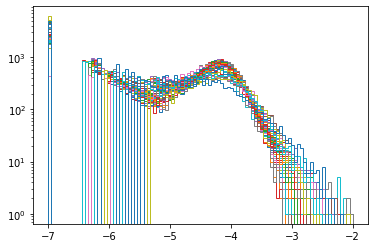

In [3]:
bins = np.linspace(-7, -2, 100)
for tissue in tissues:
    plt.hist(np.log10(1e-7+proteinatlas[tissue]), histtype='step', bins=bins)
plt.yscale('log')

In [4]:
L = 9

In [5]:
humanproteome = load_proteome_as_df('Human')
humanproteome = humanproteome[~(humanproteome['Gene'] == '')]
humanproteome = humanproteome.set_index('Gene')
humanproteome = humanproteome.squeeze()
humanproteome = humanproteome[humanproteome['Sequence'].str.len()>L]

In [6]:
missing = set(proteinatlas['Gene'].unique()) - set(humanproteome.index)

In [7]:
proteinatlas = proteinatlas[~proteinatlas['Gene'].isin(missing)]
proteinatlas[tissues] = proteinatlas[tissues].div(proteinatlas[tissues].sum(axis=0), axis=1)

In [8]:
proteinatlas_geneindex = proteinatlas.groupby('Gene').agg('sum')
sequences = np.array(humanproteome['Sequence'])

In [9]:
def generator(N, k, sequences, p):
    N = int(N)
    counter = 0
    seqs = np.random.choice(sequences, p=expression, size=N)
    lengths = np.array([len(seq) for seq in seqs])
    startindices = np.random.randint(0, lengths-k)
    for sequence, startindex in zip(seqs, startindices):
        kmer = sequence[startindex:startindex+k]
        if isvalidaa(kmer):
            yield kmer

In [34]:
observables_dict = {'fi':dict(), 'cij':dict(), 'cijk':dict()}
selected_tissues = np.random.choice(tissues, 5)
for tissue in selected_tissues:
    expression = np.array([proteinatlas_geneindex.loc[gene][tissue] if gene in proteinatlas_geneindex.index else 0.0
              for gene in humanproteome.index])
    expression /= np.sum(expression)
    matrix = kmers_to_matrix(generator(1e6, 9, sequences, expression))
    fi = frequencies(matrix, num_symbols=naminoacids)
    fij = pair_frequencies(matrix, num_symbols=naminoacids, fi=fi)
    cij = compute_covariance_matrix(fi, fij)
    fijk = triplet_frequencies(matrix, num_symbols=naminoacids)
    cijk = compute_cijk(fijk, fij, fi)
    observables_dict['fi'][tissue] = fi
    observables_dict['cij'][tissue] = cij
    observables_dict['cijk'][tissue] = cijk

In [35]:
for dataset in ['train']:
    params = np.load('../maxent/data/%s_observables.npz'%dataset)
    for observable in observables_dict.keys():
        observables_dict[observable][dataset] = params[observable]

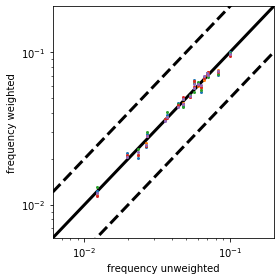

In [36]:
fig, ax = plt.subplots(figsize=(4, 4))
fi = observables_dict['fi']['train']
xmin, xmax = 0.5*np.amin(fi), 2*np.amax(fi)
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
for tissue in selected_tissues:
    ax.plot(np.mean(fi, axis=0), np.mean(observables_dict['fi'][tissue], axis=0), 'o', ms=2,
            label=tissue.split('-')[-1][:-5])
#ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency unweighted')
ax.set_ylabel('frequency weighted')
fig.tight_layout()
fig.savefig('main.png')

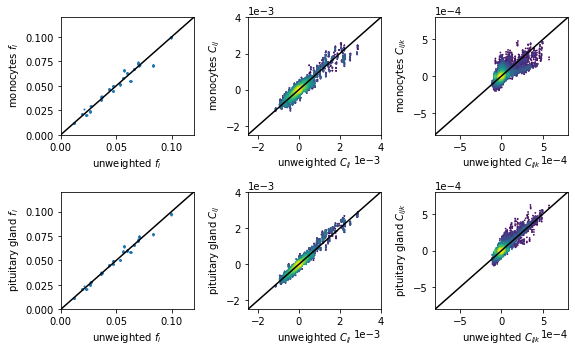

In [40]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=3, nrows=2)

for j, (observable, label, lims, flattener) in enumerate([('fi', '$f_i$', (0, 0.12), np.ravel),
                                               ('cij', '$C_{ij}$', (-0.0025, 0.004), flatten_ij),
                                               ('cijk', '$C_{ijk}$', (-8e-4, 8e-4), flatten_ijk)]):
    for i, dataset in enumerate([selected_tissues[0], selected_tissues[1]]):
        ax = axes[i, j]
        if observable in ['cij', 'cijk']:
            plotting.density_scatter(flattener(observables_dict[observable]['train']),
                             flattener(observables_dict[observable][dataset]),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=40, ax=ax)
        else:
            ax.plot(flattener(observables_dict[observable]['train']),
                    flattener(observables_dict[observable][dataset]),
                    'o', ms=1)
        
        ax.set_xlabel('unweighted %s'%label)
        ax.set_ylabel('%s %s'%(dataset[12:-5], label))
        ax.plot(lims, lims, 'k')
        ax.set_xlim(*lims)
        ax.set_ylim(*lims)

for ax in axes[:, 1:].flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0))

fig.tight_layout()
fig.savefig('higher_order_stats.png')